<a href="https://colab.research.google.com/github/Pranov1984/Application-of-NLP-in-Automated-Classification-of-ticket-routing/blob/master/Classification_and_Automation_of_Ticket_routing_version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Understanding Problem statement</h2>

<h3>1. Representing the problem statement as use cases for a fictional company called GL Software</h3>

![Use cases](https://drive.google.com/uc?id=1QE_64Dxqk_5QTDS_wUltMIKRGAhWHybm)

<h3>2. Interpreting the details in problem statement</h3>

Responsibilities of L1/L2 and L3/Functional groups

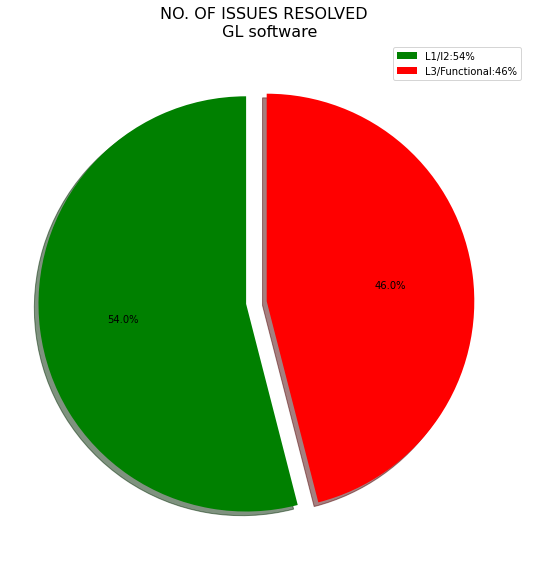

In [0]:

labels = ['L1/l2:54%','L3/Functional:46%'] 
colors = ['green', 'red'] 
explode =(0.1,0) 
fig, ax1 = plt.subplots(figsize = (16,8)) 
ax1.pie([54,46], explode = explode, colors=colors, startangle=90, autopct='%.1f%%', shadow = True) 
plt.title('NO. OF ISSUES RESOLVED \n GL software', fontsize = 16) 
ax1.legend(labels, loc = 'upper right') 
plt.tight_layout() 
plt.show()

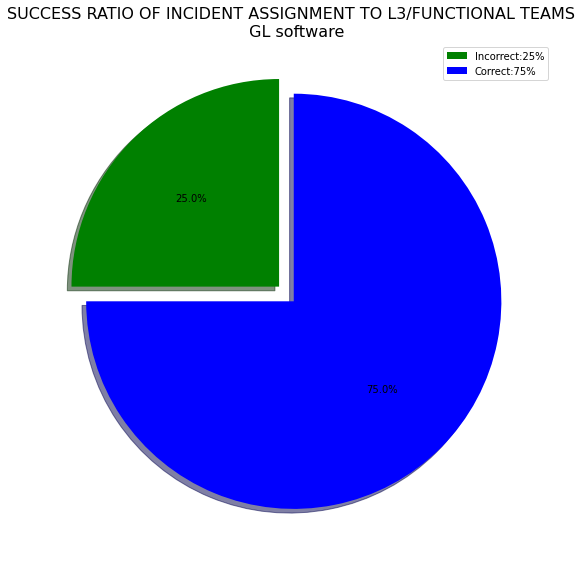

In [0]:
labels = ['Incorrect:25%','Correct:75%'] 
colors = ['green', 'blue'] 
explode =(0.1,0) 
fig, ax1 = plt.subplots(figsize = (16,8)) 
ax1.pie([25,75], explode = explode, colors=colors, startangle=90, autopct='%.1f%%', shadow = True) 
plt.title('SUCCESS RATIO OF INCIDENT ASSIGNMENT TO L3/FUNCTIONAL TEAMS \n GL software', fontsize = 16) 
ax1.legend(labels, loc = 'upper right') 
plt.tight_layout() 
plt.show()

<b>Observations</b>
<ul>
<li>Apart from resolving issues, L1/L2 spend a lot of time (almost 1 FTE) in assigning issues to L3/Functional groups.</li>
<li>Even if 50% percent of the assignment work is automated, it will save a lot of time and effort for L1/L2 and might improve assignment accuracy and faster issue resolution.</li>
</ul>

<h3>3. Understanding the goal</h3>

<b>Primary Objective</b>
<p>Automate incidents assignment to right functional groups, based on the provided data, to a certain level of accuracy which helps in saving time and effort of L1/L2 groups.</p>
<p>Also, the effort and time saved by automation should result in quick and better issue resolutions.</p>

<h3>4. Questions to business regarding the source of data</h3>
<ul>
<li>Assuming this data has been collected after SOP and assignment done by L1/L2</li>
<li>Assuming the data provided does not include direct assignments to L3</li>
<li>Is this seasonal/peak time data?</li>
</ul>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab Notebooks/AIML/Capstone/'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

In [0]:
df=pd.read_excel(project_path+'Input Data Synthetic.xlsx', lines=True)
df.columns

Index(['Short description', 'Description', 'Caller', 'Assignment group'], dtype='object')

In [0]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [0]:
df.columns=['ShortDescription','Description', 'Caller', 'AssignmentGroup']

In [0]:
df.shape

(8500, 4)

In [0]:
df.describe().T

,count,unique,top,freq
ShortDescription,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
AssignmentGroup,8500,74,GRP_0,3976


*   Password reset seems to be highest re-occuring theme or short description
*   A specific caller has a very high frequency of raising tickets. Caller could be an important feature
*   The data needs to be cleaned and checked again as the top word in Description is a stop word






Cheack a few descriptions

In [0]:
print('Description:', df.iloc[0,1])

print('Short Description:',df.iloc[0,0])

Description: -verified user details.(employee# & manager name)
-checked the user name in ad and reset the password.
-advised the user to login and check.
-caller confirmed that he was able to login.
-issue resolved.
Short Description: login issue


In [0]:
print('Description:', df.iloc[1,1])

print('Short Description:',df.iloc[1,0])


Description: 

received from: hmjdrvpb.komuaywn@gmail.com

hello team,

my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?

kind 
Short Description: outlook


In [0]:
print('Description:', df.iloc[3,1])

print('Short Description:',df.iloc[3,0])

Description: unable to access hr_tool page
Short Description: unable to access hr_tool page


In [0]:
df.AssignmentGroup.nunique()

74


# Observations 
*  There are 74 unique teams/groups to which the received tickets are assigned
*  It seems a very high number
*  Unless each group has a substantial number of tickets assigned, having so many groups with very few observations could be counter productive for machine learning
*   We also need to check if the distribution of tickets amongst all groups is equitable or not. If not we have an imbalanced dataset which will need us to treat it






In [0]:
df.AssignmentGroup.value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_70       1
GRP_61       1
GRP_67       1
GRP_73       1
Name: AssignmentGroup, Length: 74, dtype: int64



*   We see GRP_0 has nearly half of the total number of tickets received
*   Next highest drops down to 661 which is almost 1/6th of the highest
*   We see a lot of groups with only ticket assigned
*   Groups with only one ticket assigned will not add much value to any machine learning framework

Let's review the above distribution in terms of percentage





In [0]:
df.AssignmentGroup.value_counts(normalize=True)

GRP_0     0.467765
GRP_8     0.077765
GRP_24    0.034000
GRP_12    0.030235
GRP_9     0.029647
            ...   
GRP_64    0.000118
GRP_70    0.000118
GRP_61    0.000118
GRP_67    0.000118
GRP_73    0.000118
Name: AssignmentGroup, Length: 74, dtype: float64

There is imbalance in the dataset. This needs to be treated

*   As seen earlier, extreme imbalance is noticed in the dataset
*   GRP_0 constitutes 47% of the total tickets received
*   Next best is  GRP_8 with 8% assignment

In [0]:
a=df.AssignmentGroup.value_counts(normalize=True)
len(a.index[a<0.01]) , len(a.index[a>=0.01])

(55, 19)

One category constitutes more than 45% of the total observations or tickets 

*   If we do not consider GRP_0, none of the other groups individually consitute more than 10% of the total tickets.
*   The second highest in terms of tickets received is Group_8 with 7.77% of total tickets
*   55 groups, when considered individually, have less than 1% of total tickets
*   This is highly skewed/imbalanced data
*   The groups which have ticket assignment % between 0.7 and 1% are given below

In [0]:
#Identification of the groups who have less than 7% and more than 1% of total tickets
a.index[(a<0.07) & (a>0.01)]

Index(['GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19', 'GRP_3', 'GRP_6',
       'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25', 'GRP_33', 'GRP_4',
       'GRP_29', 'GRP_18'],
      dtype='object')

**Check the frequency distribution of tickets assigned to all groups respectively to visualize the imbalanceness in the data**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]), <a list of 74 Text major ticklabel objects>)

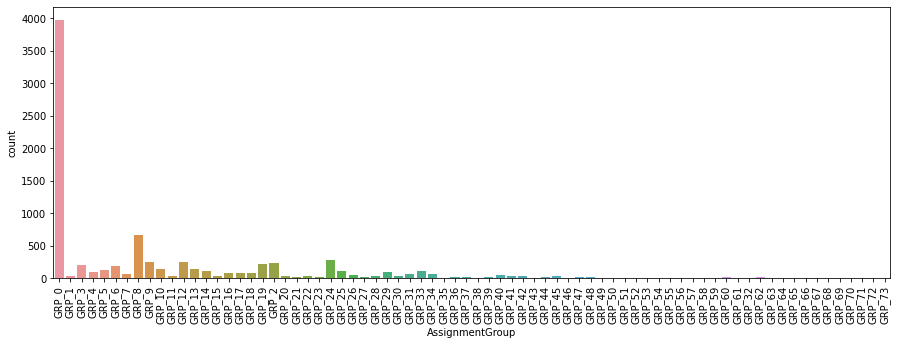

In [0]:
plt.figure(figsize=(15,5))
sns.countplot(df['AssignmentGroup'])
plt.xticks(rotation=90)



1.   **We clearly see in comparison with GRP_0, rest of the groups have minimal tickets assigned**
2.   **A majority of groups have maybe only 1 ticket assigned as can be seen in the right hand section of the above plot**



**Check the frequency distribution of tickets assigned to groups other than the top two groups in terms of number of tickets received**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]), <a list of 72 Text major ticklabel objects>)

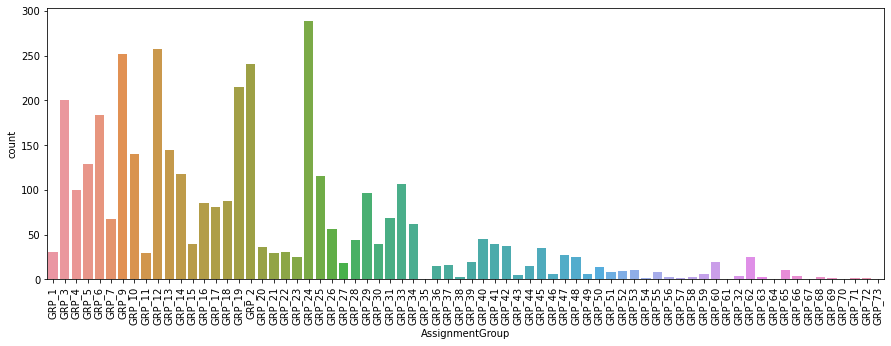

In [0]:
plt.figure(figsize=(15,5))
sns.countplot(df[(df['AssignmentGroup']!='GRP_0') & (df['AssignmentGroup']!='GRP_8')]['AssignmentGroup'])
plt.xticks(rotation=90)

*italicized text*
*   **We have a lot of ticket assignments with a frequency of less than 100.**
*   **Best approach is to aggregate all tickets with frequency less than 100  or 200 into one group to make the data a little less imbalanced**
*   **This will give any machine learning algorithm a better chance to learn the underlying patterns in the data**
*   **We see lot of groups with less than 100 (or 200)tickets assigned. Our approach to tackle this problem is to begin with aggregating all groups with less than 100 (or 200) tickets assigned**
*   **The category with all these aggregated tickets will continue to be required to be manually reviewed. But the rest of the categories may be possible to be automated for ticket assignment**
*   **The bottomline is we may be sacrificing automation of ticket assignment which are rare but will automate the ticket assignment of more frequent issues which will still be a great help to the company**



## Let's check how many groups we would have after the above aggregation ** 






In [0]:
a = df.AssignmentGroup.value_counts()
a = a[a < 200].index
print("No. of unique groups for ticket assignment after agrregating all groups with less than 200 tickets: ", df.AssignmentGroup.nunique() - len(a)+1)

No. of unique groups for ticket assignment after agrregating all groups with less than 200 tickets:  9


In [0]:
#convert all categories with less than 200 freq as 'Grouped_Assignment'
df['New_AssignmentGroup'] = np.where(df.groupby('AssignmentGroup')['AssignmentGroup'].transform('size') < 200, 'Grouped_Assignment', df['AssignmentGroup'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

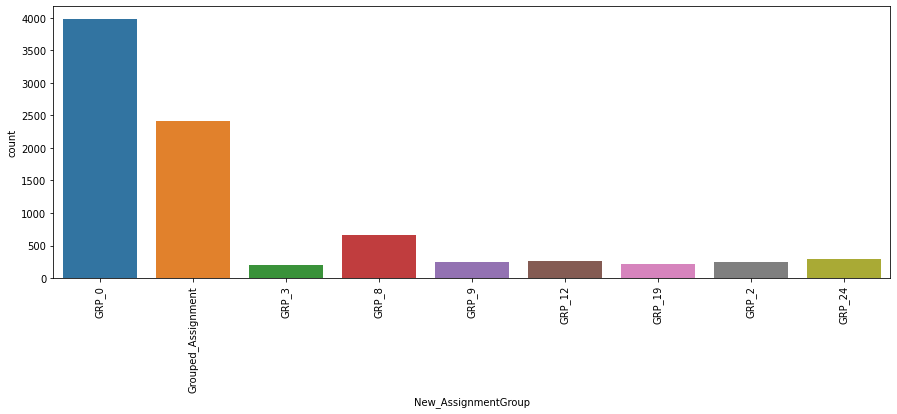

In [0]:
plt.figure(figsize=(15,5))
sns.countplot(df['New_AssignmentGroup'])
plt.xticks(rotation=90)

We still see a very high imbalance. 
We may have to explore some techiques like **undersampling of majority class , oversampling of minority class or SMOTE** to deal with the problems that can be caused by the unbalanced dataset

In [0]:
df[df['New_AssignmentGroup']=="Grouped_Assignment"].shape[0]

2409

In [0]:
df.isnull().sum()

ShortDescription       8
Description            1
Caller                 0
AssignmentGroup        0
New_AssignmentGroup    0
dtype: int64

#Find the rows with missing values

In [0]:
null_data = df[df.isnull().any(axis=1)]
null_data

,ShortDescription,Description,Caller,AssignmentGroup,New_AssignmentGroup
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34,Grouped_Assignment
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0,GRP_0


#Need to use Description where Short Description is missing and vice-versa for treating missing values

In [0]:
null_data.index

Int64Index([2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341, 4395], dtype='int64')

In [0]:
df.loc[4395,'Description']=df.loc[4395,'ShortDescription']
df['ShortDescription'] = df.apply(lambda row: row['Description'] if pd.isna(row['ShortDescription']) else row['ShortDescription'], axis=1)

In [0]:
df.isnull().sum().sum()

0

Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis of the reviews.

In [0]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Description']=df['Description'].apply(lambda x:expand_contractions(x))
df['ShortDescription']=df['ShortDescription'].apply(lambda x:expand_contractions(x))

#Create a word cloud

In [0]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

gen_freq(df.Description.str)

the                                        6312
to                                         6298
in                                         3172
is                                         3003
from:                                      2499
                                           ... 
us?                                           1
instuctrion"                                  1
lapping                                       1
æ³•æ£€æŸ¥æ‹¼å†™å’Œè¯­æ³•é”™è¯¯"ï¼Œä¹Ÿæ—       1
designate                                     1
Length: 29992, dtype: int64

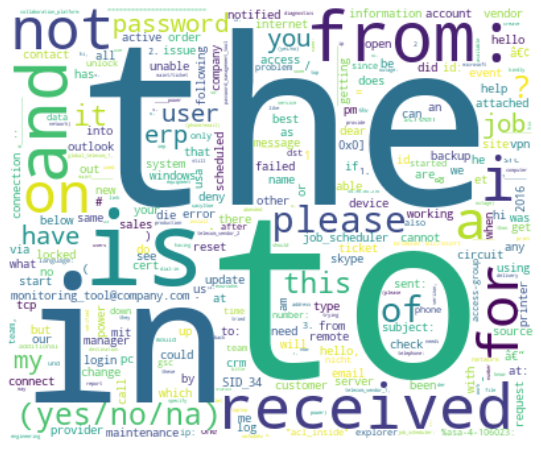

In [0]:
#Generate a word cloud

#Import libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=500, 
               background_color='white').generate_from_frequencies(gen_freq(df.Description.str))

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#We could get a more meaningful word cloud with cleaned text i.e.
1. Remove stop words, punctuations etc
2. Remove digits, symbols etc. if any
3. Lammetize the sentences to reduce the number of words in use

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
#stop_words.append()

def text_cleaner(text):
    #converting to lowercase
    newString = text.lower()
    #removing links
    newString = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', newString) 
    #removing text inside ()
    newString = re.sub(r'\([^)]*\)', '', newString)
    #removing text inside []
    newString = re.sub(r'\{[^)]*\}', '', newString)
    #fetching alphabetic characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    #removing stop words
    tokens = [w for w in newString.split() if not w in stop_words] 
    long_words=[]
    for i in tokens:
        #removing short words
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
cleaned_text=[]
for i in df.Description:
    cleaned_text.append(text_cleaner(i)) 

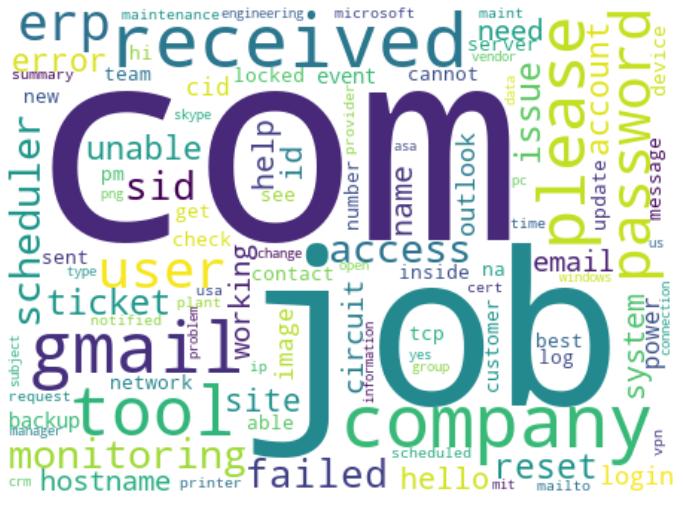

In [0]:
text = df.Description.apply(lambda x: text_cleaner(x))
word_freq = gen_freq(text.str)

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [0]:
print('5 random Descriptions which are assigned to GRP_0: \n')
cl = df.loc[df.AssignmentGroup == 'GRP_0', ['Description']].sample(5).values
for c in cl:
    print(c[0])

5 random Descriptions which are assigned to GRP_0: 

unable to log in to collaboration_platform 
engineering_tool company and company not working 


received from: blktuiae.jzakfmhw@gmail.com

fyi
now access to the  internet  - webside allways offline

till this weekend

i am located in fÃ¼rth _ germany


vpn query for user vvtdfettc67


received from: luxdnsvk.qmnyzcfs@gmail.com

dear sir,

my laptop currently has 2010 version of microsoft outlook.
kindly help me in getting the lauacyltoe hxgaycze version of the same.

with best 


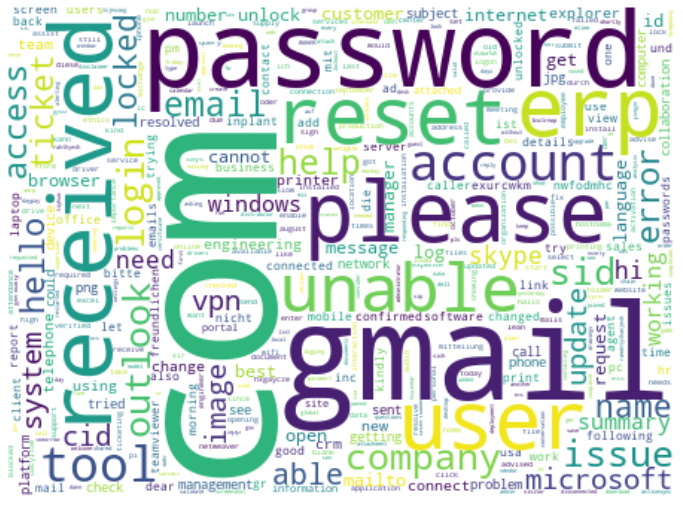

In [0]:
#Let's take a look at the word cloud for tickets assigned to Group_0

text = df[df['AssignmentGroup']=='GRP_0'].Description.apply(lambda x: text_cleaner(x))
word_freq = gen_freq(text.str)

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=500, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

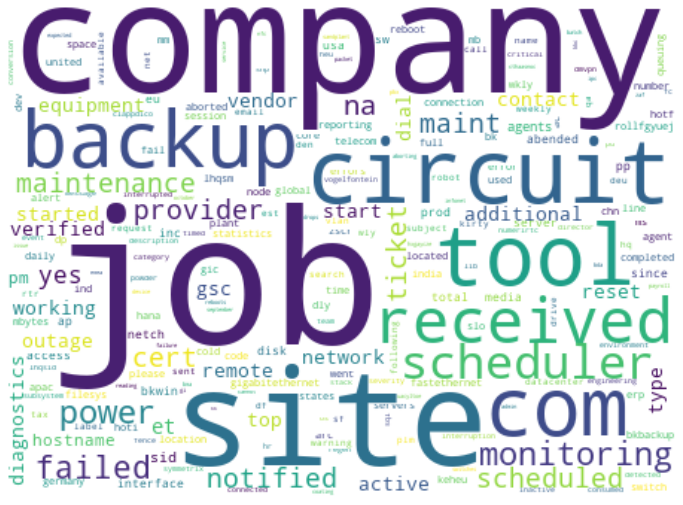

In [0]:
#Let's take a look at the word cloud for tickets assigned to Group_8

text = df[df['AssignmentGroup']=='GRP_8'].Description.apply(lambda x: text_cleaner(x))
word_freq = gen_freq(text.str)

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=500, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

com 3640
job 2550
company 2386
received 2369
gmail 2144
tool 1981
password 1334
user 1199
erp 1158
monitoring 988
scheduler 969
access 950
failed 907
sid 905
ticket 874
reset 837
issue 825
unable 784
error 728
account 701


Text(0.5, 1.0, 'Top 20 words in headlines after removing stop words')

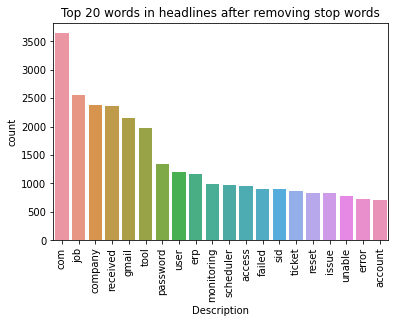

In [0]:
#The distribution of top unigrams after removing stop words
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(cleaned_text, 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Description' , 'count'])

x=pd.DataFrame(df2.groupby('Description').sum()['count'].sort_values(ascending=False))
import seaborn as sns
sns.barplot(x=x.index, y=x['count'])
plt.xticks(rotation=90)
plt.title('Top 20 words in headlines after removing stop words')

received monitoring tool 961
monitoring tool company 961
tool company com 961
failed job scheduler 809
company com job 785
job job failed 475
job failed job 475
com job job 468
gmail com hello 379
cid image png 270
scheduled maintenance company 253
gmail com hi 210
cid image jpg 208
gmail com mailto 206
src inside dst 185
access group acl 185
group acl inside 185
browser microsoft internet 168
microsoft internet explorer 168
internet explorer email 168


Text(0.5, 1.0, 'Top 20 trigrams in headlines after removing stop words')

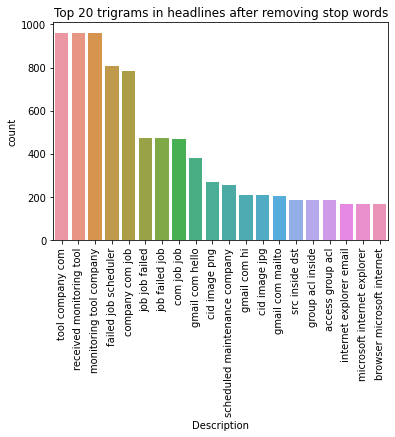

In [0]:
# The distribution of Top trigrams after removing stop words

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cleaned_text, 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['Description' , 'count'])
x=pd.DataFrame(df6.groupby('Description').sum()['count'].sort_values(ascending=False))
import seaborn as sns
sns.barplot(x=x.index, y=x['count'])
plt.xticks(rotation=90)
plt.title('Top 20 trigrams in headlines after removing stop words')

Tickets are generally received to solve a problem. But some of them are associated with anger, frustrations etc. because something may not working as intended whereas some are requests. The formers are generally a form of escalations and need to be resolved at the earliest to prevent the customer from making a complaint. Hence it would be ideal to identify the sentiment associated with a review request and see what can be done with this information 

Let's checking the polarity of the tickets received, i.e., how much a text is positive or negative in sentiment. We can check the polarity of a review using the TextBlob library in Python:



In [0]:
from textblob import TextBlob
df['polarity']=df['Description'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [0]:
df.polarity.max() , df.polarity.min()

(1.0, -1.0)

Let's look at some of the descriptions associcated with the tickets and have a negative feeling representation

In [0]:
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['Description']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 

received from: wktesmbp.lorjymef@gmail.com

dear team,
we got a stock recall notic#plant_101-101016-01 for mm#3098450 & should return 373pc materials to plant_101,then i created sto#5019320060 base on this recall.
dn#916955708/105pc was just created against the sto, pls. help to run out the dn of rest 268pc ,thx a lot!
[cid:image001.png@01d223c2.0ac78080]
b.rgds
judthtihty.zhuyhts
company hardpoint apac-wgq dc



Review 2:
 name:mikhghytr karaffa
language:
browser:microsoft internet explorer
email:vfrdxtqw.jfbmsenz@gmail.com
customer number:
telephone:
summary:please usa me access to the dunham and bradstreet data base.
Review 3:
 see attachment
contact :  (uk)


**The above looks like requests for instructions to be followed**








In [0]:
print("5 Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[0:5].index]['Description']):
  print('Review {}:\n'.format(index+1),review)

5 Random Reviews with Highest Polarity:
Review 1:
 

received from: yhmzxcia.heszapvl@gmail.com

please help to reset pass word for erp SID_34
user id : hertel


best 
Review 2:
 hallo,

bitte fÃ¼r jannek hÃ¼ndling zugriff auf den ordner department / ausbildung.

mit freundlichen grÃ¼ÃŸen / best 
Review 3:
 

received from: pnroqajb.psbyfhkg@gmail.com

hallo helpteam,

im departmentlaufwerk von germany steel ist im ordner ehs der unterordner mbs verschwunden. bitte wieder herstellen.

vielen dank!

viele grÃ¼ÃŸe / best 
Review 4:
 

received from: fdqjsygx.aivdjqtr@gmail.com

hallo,

der drucker â€žem96" scannt keine dokumente ein.

fehlermeldung: zugriff Ã¼berprÃ¼fen fÃ¼r folgende ziele fehlgeschlagen:

                \\HostName_579\_kmscan\em96<file:///\\HostName_579\_kmscan\em96>: der pfad kann nicht gefunden werden.

der fehler lÃ¤sst sich auch durch mehrmaliges ein- und ausschalten nicht beheben.

mit freundlichen grÃ¼ÃŸen / best 
Review 5:
 

received from: fdqjsygx.aivdjqtr@gma


*   **The above looks like inelligibel languages with high polarity or request to troubleshoot**
*   **Let's check if these assigned to the same group**



In [0]:
df.iloc[df['polarity'].sort_values(ascending=False)[0:10].index][['Description','New_AssignmentGroup','polarity']]

,Description,New_AssignmentGroup,polarity
3320,\n\nreceived from: yhmzxcia.heszapvl@gmail.com...,GRP_0,1.0
1146,"hallo,\n\nbitte fÃ¼r jannek hÃ¼ndling zugriff ...",GRP_12,1.0
4897,\r\n\r\nreceived from: pnroqajb.psbyfhkg@gmail...,GRP_0,1.0
570,\r\n\r\nreceived from: fdqjsygx.aivdjqtr@gmail...,Grouped_Assignment,1.0
6807,\r\n\r\nreceived from: fdqjsygx.aivdjqtr@gmail...,GRP_12,1.0
6098,"hi gartryhu,\r\n\r\næˆ‘çŽ°åœ¨ç”µè„‘æœ‰å‡ ä¸ªé—...",Grouped_Assignment,1.0
3997,\r\n\r\nreceived from: yzodcxkn.zyewibop@gmail...,Grouped_Assignment,1.0
4874,\r\n\r\nreceived from: bmudkpie.qolrvbip@gmail...,Grouped_Assignment,1.0
2708,hello\r\n\r\nplease urgently fix!\r\n\r\nmwstã...,Grouped_Assignment,1.0
265,\r\n\r\nreceived from: fcyuqvoj.ajqeidlm@gmail...,GRP_0,1.0


In [0]:
df.iloc[df['polarity'].sort_values(ascending=True)[0:10].index][['Description','New_AssignmentGroup','polarity']]

,Description,New_AssignmentGroup,polarity
1796,\n\nreceived from: wktesmbp.lorjymef@gmail.com...,Grouped_Assignment,-1.00
7492,name:mikhghytr karaffa\nlanguage:\nbrowser:mic...,GRP_0,-0.80
3555,see attachment\ncontact : (uk),GRP_0,-0.75
3388,\r\n\r\nreceived from: jxgobwrm.qkugdipo@gmail...,GRP_0,-0.75
7543,\r\n\r\nreceived from: vnsmwqhb.ogtpenjd@gmail...,GRP_0,-0.75
2988,both the numbers for gso are not working.\r\ng...,Grouped_Assignment,-0.75
1536,benelthyux team has bad phone connection of in...,Grouped_Assignment,-0.70
5644,bad monitor lbdw7402365,GRP_3,-0.70
4946,\r\n\r\nreceived from: lijrvdgh.wfhmdsoa@gmail...,GRP_0,-0.70
4593,\r\n\r\nreceived from: gasbfqvp.fmvqgjih@gmail...,Grouped_Assignment,-0.70


Lets  visualize to see if there is any differentiation on the basis of polarity when the tickets are assigned

Text(0.5, 1.0, 'Negative to Neutral Sentiment Tickets')

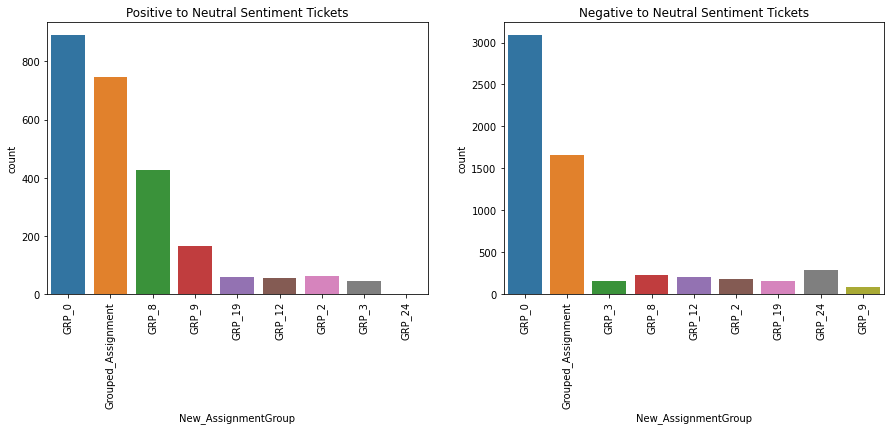

In [0]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(df[df.polarity<0]['New_AssignmentGroup'])
plt.xticks(rotation=90)
plt.title('Positive to Neutral Sentiment Tickets')

plt.subplot(1,2,2)
sns.countplot(df[df.polarity>=0]['New_AssignmentGroup'])
plt.xticks(rotation=90)
plt.title('Negative to Neutral Sentiment Tickets')



*   Higher volume of the below neutral polarity descriptions assigned to Group_0 and Grouped_Assignment
*   The teams with assignments of tickets have much different frequencies



In [0]:
!pip install textstat

     |████████████████████████████████| 102kB 2.2MB/s 
     |████████████████████████████████| 3.0MB 9.0MB/s 


Let's find the time taken to read the text and whether they are readable or not

**The readability of a text document can be checked using various readability indices like Flesch Reading Ease, Dale Chall Readability Score, and Gunning Fog Index.**

For this, we can use the textstat library in Python. Textstat is typically used for determining readability, complexity, and grade level of a particular corpus. Each of these indices works on a different methodology for determining the readability level of a document.

In [0]:
import textstat
df['dale_chall_score']=df['Description'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['flesh_reading_ease']=df['Description'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['Description'].apply(lambda x: textstat.gunning_fog(x))

print('Dale Chall Score of tickets assigned to GRP_0 =>',df[df['AssignmentGroup']=='GRP_0']['dale_chall_score'].mean())

print('Flesch Reading Score of tickets assigned to GRP_0 =>',df[df['AssignmentGroup']=='GRP_0']['flesh_reading_ease'].mean())

print('Gunning Fog Index of tickets assigned to GRP_0=>',df[df['AssignmentGroup']=='GRP_0']['gunning_fog'].mean())

Dale Chall Score of tickets assigned to GRP_0 => 10.277947686116725
Flesch Reading Score of tickets assigned to GRP_0 => 41.09460010060366
Gunning Fog Index of tickets assigned to GRP_0=> 10.852640845070333


In [0]:
df['dale_chall_score']=df['Description'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['flesh_reading_ease']=df['Description'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['Description'].apply(lambda x: textstat.gunning_fog(x))

print('Dale Chall Score of tickets assigned to groups other than GRP_0 =>',df[df['AssignmentGroup']!='GRP_0']['dale_chall_score'].mean())

print('Flesch Reading Score of tickets assigned to groups other than GRP_0 =>',df[df['AssignmentGroup']!='GRP_0']['flesh_reading_ease'].mean())

print('Gunning Fog Index of tickets assigned to groups other than GRP_0=>',df[df['AssignmentGroup']!='GRP_0']['gunning_fog'].mean())

Dale Chall Score of tickets assigned to groups other than GRP_0 => 10.157453580901752
Flesch Reading Score of tickets assigned to groups other than GRP_0 => 21.677206012378218
Gunning Fog Index of tickets assigned to groups other than GRP_0=> 18.445214412024484




*   **The readability of descriptions assigned to Group_0 is higher if we go by Flesh Reading score. BY Dale Chall score and gunning score, the readability standards are similar.** 
*   **The textstat library has can tell us the standard of descriptions by telling us which grade students can read the text. It provides the text_standard() function. that uses various readability checking formulas, combines the result and returns the grade of education required to understand a particular document completely.**


In [0]:
df['Text_standard']=df['Description'].apply(lambda x: textstat.text_standard(x))
df.head()

,ShortDescription,Description,Caller,AssignmentGroup,New_AssignmentGroup,Cleaned_Description,polarity,dale_chall_score,flesh_reading_ease,gunning_fog,Text_standard
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,GRP_0,verified user details checked user name ad res...,0.45,10.65,47.46,15.3,14th and 15th grade
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,GRP_0,received hmjdrvpb komuaywn gmail com hello tea...,0.60,9.30,46.10,13.2,12th and 13th grade
2,cant log vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,GRP_0,received eylqgodm ybqkwiam gmail com hi cannot...,1.00,8.49,60.31,4.4,7th and 8th grade
3,unable access hr tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,GRP_0,unable access hr tool page,-0.50,10.20,83.32,2.0,1st and 2nd grade
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,GRP_0,skype error,0.00,11.63,35.61,0.8,-1th and 0th grade


In [0]:
print('Text Standard of Descriptions =>',df['Text_standard'].mode())

Text Standard of Descriptions => 0    11th and 12th grade
dtype: object


 
*   Let’s take a look at the reading time of Descriptions. An average adult reads about 250 words per minute.
*   We can also calculate the reading time of a document using the textstat library. It provides the reading_time() function, which takes a piece of text as an argument and returns the reading time for it in seconds.

In [0]:
df['reading_time']=df['Description'].apply(lambda x: textstat.reading_time(x))
print('Reading Time of each Description =>',df['reading_time'].mean())

Reading Time of each Description => 2.481712941176483


# Consolidate Short Description, Description and callers together for our text to be used for model building

In [0]:
df.columns

Index(['ShortDescription', 'Description', 'Caller', 'AssignmentGroup',
       'New_AssignmentGroup'],
      dtype='object')

In [0]:
cleaned_text=[]
for i in df['Description']:
    cleaned_text.append(text_cleaner(i))

df['Cleaned_Description'] = cleaned_text

cleaned_text=[]
for i in df['ShortDescription']:
    cleaned_text.append(text_cleaner(i))

df['ShortDescription'] = cleaned_text

df['Consolidated_Text']=df['Cleaned_Description']+ df['ShortDescription']+ df['Caller']

The data is still quite imbalanced. Next steps are given below

*   Let's try to split the data for model building
*   Create embeddings for model building
*   Build models for automated ticket assignment
*   Evaluation metric to be used for comparison of models is accuracy and precision

# Leverage tf-idf concept to generate word embeddings and train ML models

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import pandas as pd

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [0]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(df['Consolidated_Text'], df['New_AssignmentGroup'], test_size = 0.25)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [0]:
valid_x.shape, valid_y.shape

((2125,), (2125,))

In [0]:
unique, counts = np.unique(train_y, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 2973]
 [   1  199]
 [   2  154]
 [   3  161]
 [   4  225]
 [   5  155]
 [   6  496]
 [   7  194]
 [   8 1818]]


# Feature Engineering

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus



In [0]:
# word level tf-idf

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train_x)
xtrain_tfidf =  tfidf_vect.transform(train_x)

tfidf_vect.fit(valid_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [0]:
xvalid_tfidf.shape, xtrain_tfidf.shape

((2125, 5000), (6375, 5000))

In [0]:
# ngram level tf-idf 

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=5000)
tfidf_vect_ngram.fit(train_x)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)

tfidf_vect_ngram.fit(valid_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

In [0]:
# characters level tf-idf

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train_x)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x)
tfidf_vect_ngram_chars.fit(valid_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


# Model Building

The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement following different classifiers for this purpose:

Naive Bayes Classifier

Linear Classifier

Support Vector Machine

Bagging Models

Boosting Models


The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.

In [0]:
from sklearn.metrics import classification_report, accuracy_score,precision_score ,confusion_matrix

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    accuracy = accuracy_score(predictions, valid_y)
    precision_macro = precision_score(predictions, valid_y, average='macro')
    precision_avg = precision_score(predictions, valid_y, average='weighted')
    print(classification_report(valid_y,predictions))

In [0]:
# Naive Bayes on Word Level TF IDF Vectors
from sklearn import naive_bayes

Model_Results = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", Model_Results)

# Naive Bayes on Ngram Level TF IDF Vectors
Model_Results = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", Model_Results)

# Naive Bayes on Character Level TF IDF Vectors
Model_Results = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", Model_Results)


              precision    recall  f1-score   support

           0       0.43      0.50      0.46      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.21      0.04      0.06       165
           7       0.00      0.00      0.00        58
           8       0.27      0.43      0.33       591

    accuracy                           0.36      2125
   macro avg       0.10      0.11      0.10      2125
weighted avg       0.30      0.36      0.32      2125

NB, WordLevel TF-IDF:  None
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1003
           1       0.18      0.09      0.12        58
           2       0.00      0.00      0.00        61
           3       0.14      0.04      0.06       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# The accuracy and precision are not encouraging. Let's try another classifier i.e. SVM

In [0]:
from sklearn import svm 

# SVM on Word Level TF IDF Vectors
Model_Results = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, WordLevel TF-IDF: ", Model_Results)

              precision    recall  f1-score   support

           0       0.45      0.69      0.55      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.28      0.28      0.28       591

    accuracy                           0.40      2125
   macro avg       0.08      0.11      0.09      2125
weighted avg       0.29      0.40      0.34      2125

SVM, WordLevel TF-IDF:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# SVM on Ngram Level TF IDF Vectors
Model_Results = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, WordLevel TF-IDF: ", Model_Results)

              precision    recall  f1-score   support

           0       0.54      0.85      0.66      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.40      0.35      0.37       591

    accuracy                           0.50      2125
   macro avg       0.10      0.13      0.11      2125
weighted avg       0.36      0.50      0.42      2125

SVM, WordLevel TF-IDF:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# SVM on Character Level TF IDF Vectors
Model_Results = train_model(svm.SVC(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVM, CharLevel Vectors: ", Model_Results)

              precision    recall  f1-score   support

           0       0.55      0.81      0.65      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.32      0.35      0.33       591

    accuracy                           0.48      2125
   macro avg       0.10      0.13      0.11      2125
weighted avg       0.35      0.48      0.40      2125

SVM, CharLevel Vectors:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




# The results from the SVM models are not encouraging either. Lets try a bagging model

# Implementing a Random Forest Model



In [0]:
from sklearn.ensemble import RandomForestClassifier
# RF on Word Level TF IDF Vectors
Model_Results = train_model(RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", Model_Results)

              precision    recall  f1-score   support

           0       0.45      0.07      0.13      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.27      0.88      0.41       591

    accuracy                           0.28      2125
   macro avg       0.08      0.11      0.06      2125
weighted avg       0.29      0.28      0.17      2125

RF, WordLevel TF-IDF:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# RF on Ngram Level TF IDF Vectors
Model_Results = train_model(RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("RF, WordLevel TF-IDF: ", Model_Results)

              precision    recall  f1-score   support

           0       0.49      0.11      0.19      1003
           1       0.00      0.00      0.00        58
           2       0.10      0.02      0.03        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.27      0.87      0.42       591

    accuracy                           0.30      2125
   macro avg       0.10      0.11      0.07      2125
weighted avg       0.31      0.30      0.20      2125

RF, WordLevel TF-IDF:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# RF on Character Level TF IDF Vectors
Model_Results = train_model(RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("RF, CharLevel Vectors: ", Model_Results)

              precision    recall  f1-score   support

           0       0.47      0.78      0.59      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.24      0.19      0.21       591

    accuracy                           0.42      2125
   macro avg       0.08      0.11      0.09      2125
weighted avg       0.29      0.42      0.34      2125

RF, CharLevel Vectors:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results are not encouraging again. Let's try a boosting model

# Implement Xgboost

In [0]:
from xgboost.sklearn import XGBClassifier

# XGB on Word Level TF IDF Vectors
Model_Results = train_model(XGBClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("XGB, WordLevel TF-IDF: ", Model_Results)

              precision    recall  f1-score   support

           0       0.47      0.98      0.64      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.28      0.02      0.04       591

    accuracy                           0.47      2125
   macro avg       0.08      0.11      0.08      2125
weighted avg       0.30      0.47      0.31      2125

XGB, WordLevel TF-IDF:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# XGB on Ngram Level TF IDF Vectors

Model_Results = train_model(XGBClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("XGB, WordLevel TF-IDF: ", Model_Results)

              precision    recall  f1-score   support

           0       0.49      0.98      0.65      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.27      0.04      0.07       591

    accuracy                           0.47      2125
   macro avg       0.08      0.11      0.08      2125
weighted avg       0.31      0.47      0.33      2125

XGB, WordLevel TF-IDF:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# XGB on Character Level TF IDF Vectors
Model_Results = train_model(XGBClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("XGB, CharLevel Vectors: ", Model_Results)

              precision    recall  f1-score   support

           0       0.48      0.91      0.63      1003
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        58
           8       0.29      0.11      0.16       591

    accuracy                           0.46      2125
   macro avg       0.09      0.11      0.09      2125
weighted avg       0.31      0.46      0.34      2125

XGB, CharLevel Vectors:  None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# The traditional ML models did not give good results. We could try Deep Learning Sequential models to see if we can get better performance. 
Preparation for models followed by the model itself is given below

## Get the Length of each line and find the maximum length.
As different lines are of different length. We need to pad the our sequences using the max length.

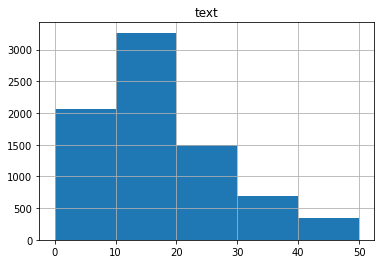

In [0]:
text_word_count = []

#populate the lists with sentence lengths
for i in df['Consolidated_Text']:
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count})

length_df.hist(bins = 5, range=(0,50))
plt.show()

In [0]:
# maxlen could be fixed at 40 which would constitute most (more than 7000) of the documents present in the datset. Set parameters of model
max_features = 10000
maxlen = 40
embedding_size = 200

In [0]:
train = df.sample(frac=0.60, random_state=99)
test = df.loc[~df.index.isin(train.index), :]

In [0]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=1, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, random_state=1, test_size=0.5)

Import required libraries for model building

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, TimeDistributed, Reshape,Dot
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

Tokenize the data

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['Consolidated_Text'])

Split the X and y for model building

In [0]:
X = tokenizer.texts_to_sequences(train['Consolidated_Text'])
X = pad_sequences(X, maxlen = maxlen)
y = pd.get_dummies(train['New_AssignmentGroup'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", y.shape[1])

Number of Samples: 5100
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   10   12 2094 2095 2815   12 2094 2095 7729 7730]
Number of Labels:  9


In [0]:
#Get the vocabulary size
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19569 unique tokens.


Word Embeding using GloVe

In [0]:
glove_file = '/content/drive/My Drive/Colab Notebooks/AIML/NLP/Week 6 - NLP Project/' + "glove.6B.zip"
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [0]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

print('Found %s word vectors.' % len(embeddings))

Found 400000 word vectors.


Create a weight matrix for words in training docs

In [0]:
embedding_dim = 200

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [0]:
df.shape, train.shape, embedding_matrix.shape, X.shape, y.shape

((8500, 8), (5100, 8), (19570, 200), (5100, 40), (5100, 9))

# Create a Bi - Directional LSTM  Model - Architecture below

In [0]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1)))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           3914000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 5

In [0]:
epochs = 20
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 22s 612ms/step - loss: 1.4947 - accuracy: 0.5181 - val_loss: 1.2389 - val_accuracy: 0.5706
Epoch 2/20
36/36 [==============================] - 22s 601ms/step - loss: 1.1068 - accuracy: 0.6209 - val_loss: 1.0495 - val_accuracy: 0.6176
Epoch 3/20
36/36 [==============================] - 21s 575ms/step - loss: 0.9727 - accuracy: 0.6658 - val_loss: 0.9885 - val_accuracy: 0.6333
Epoch 4/20
36/36 [==============================] - 21s 582ms/step - loss: 0.8569 - accuracy: 0.6983 - val_loss: 0.9255 - val_accuracy: 0.6569
Epoch 5/20
36/36 [==============================] - 21s 581ms/step - loss: 0.7426 - accuracy: 0.7351 - val_loss: 0.8908 - val_accuracy: 0.6824
Epoch 6/20
36/36 [==============================] - 21s 578ms/step - loss: 0.6466 - accuracy: 0.7699 - val_loss: 0.9320 - val_accuracy: 0.6804
Epoch 7/20
36/36 [==============================] - 21s 577ms/step - loss: 0.5760 - accuracy: 0.7959 - val_loss: 0.9184 - val_accuracy: 0.6824

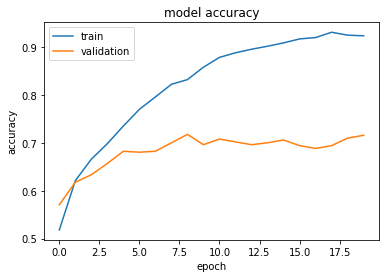

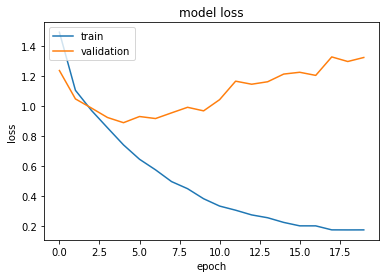

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
X_test = tokenizer.texts_to_sequences(test['Consolidated_Text'])
X_test = pad_sequences(X_test, maxlen = maxlen)
#y_test = pd.get_dummies(test['New_AssignmentGroup'])

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test['New_AssignmentGroup'])
y_test=le.transform(test['New_AssignmentGroup'])
#np.asarray(test['New_AssignmentGroup'])

In [0]:
word_index_test = tokenizer.word_index

In [0]:
y_hat = np.argmax(model.predict(X_test), axis=-1)

In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print(classification_report(y_hat,y_test))
#print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1789
           1       0.34      0.55      0.42        65
           2       0.23      0.27      0.25        74
           3       0.41      0.60      0.49        65
           4       0.84      0.89      0.86       114
           5       0.22      0.33      0.26        54
           6       0.48      0.82      0.60       169
           7       0.90      0.29      0.43       259
           8       0.58      0.67      0.62       811

    accuracy                           0.70      3400
   macro avg       0.54      0.58      0.53      3400
weighted avg       0.74      0.70      0.70      3400



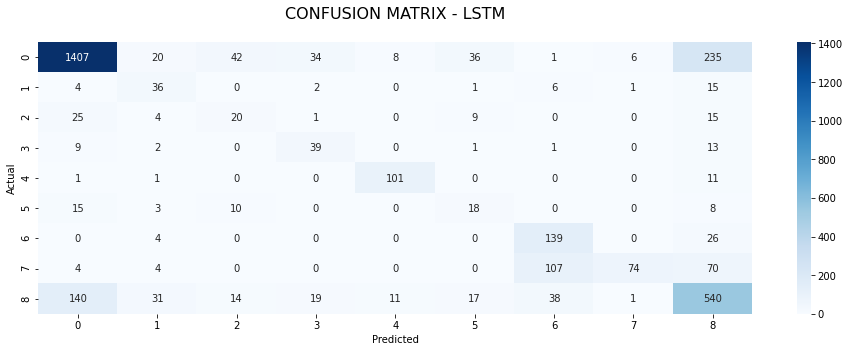

In [0]:
conf_mat=confusion_matrix(y_hat,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSTM\n", size=16);

# Change the architecture with increased lstm nodes

In [0]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1)))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


epochs = 20
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 22s 615ms/step - loss: 1.4418 - accuracy: 0.5322 - val_loss: 1.1933 - val_accuracy: 0.5824
Epoch 2/20
36/36 [==============================] - 22s 600ms/step - loss: 1.0936 - accuracy: 0.6261 - val_loss: 1.0420 - val_accuracy: 0.6098
Epoch 3/20
36/36 [==============================] - 21s 584ms/step - loss: 0.9517 - accuracy: 0.6728 - val_loss: 0.9274 - val_accuracy: 0.6529
Epoch 4/20
36/36 [==============================] - 21s 581ms/step - loss: 0.8268 - accuracy: 0.7135 - val_loss: 0.8678 - val_accuracy: 0.6647
Epoch 5/20
36/36 [==============================] - 21s 586ms/step - loss: 0.7312 - accuracy: 0.7455 - val_loss: 0.8436 - val_accuracy: 0.6961
Epoch 6/20
36/36 [==============================] - 21s 584ms/step - loss: 0.6260 - accuracy: 0.7778 - val_loss: 0.8546 - val_accuracy: 0.6941
Epoch 7/20
36/36 [==============================] - 21s 579ms/step - loss: 0.5513 - accuracy: 0.7983 - val_loss: 0.8663 - val_accuracy: 0.6863

In [0]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1682
           1       0.30      0.54      0.39        59
           2       0.22      0.22      0.22        88
           3       0.36      0.47      0.41        72
           4       0.82      0.90      0.86       110
           5       0.21      0.23      0.22        75
           6       0.82      0.63      0.71       382
           7       0.22      0.36      0.27        50
           8       0.60      0.64      0.62       882

    accuracy                           0.70      3400
   macro avg       0.49      0.53      0.50      3400
weighted avg       0.72      0.70      0.71      3400



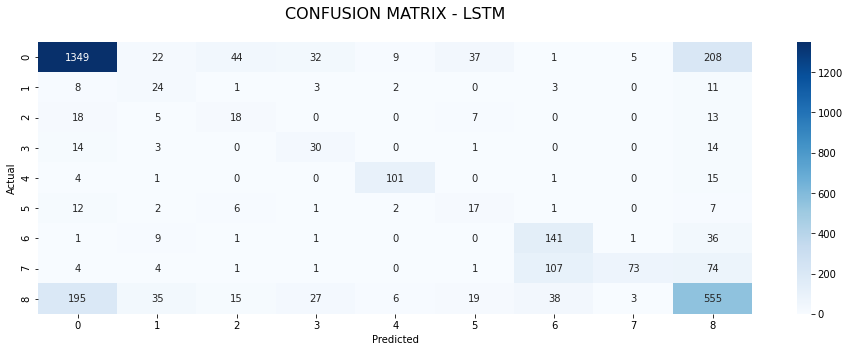

In [0]:
conf_mat=confusion_matrix(y_hat,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSTM\n", size=16);

# The performance has dipped. Try with reduced nodes and increased epochs

In [0]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1)))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


epochs = 50
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/50
36/36 [==============================] - 22s 619ms/step - loss: 1.6291 - accuracy: 0.4638 - val_loss: 1.3822 - val_accuracy: 0.5196
Epoch 2/50
36/36 [==============================] - 21s 596ms/step - loss: 1.2186 - accuracy: 0.5871 - val_loss: 1.1369 - val_accuracy: 0.5824
Epoch 3/50
36/36 [==============================] - 21s 592ms/step - loss: 1.0420 - accuracy: 0.6527 - val_loss: 1.0638 - val_accuracy: 0.6059
Epoch 4/50
36/36 [==============================] - 21s 588ms/step - loss: 0.9146 - accuracy: 0.6895 - val_loss: 0.9622 - val_accuracy: 0.6157
Epoch 5/50
36/36 [==============================] - 21s 594ms/step - loss: 0.8327 - accuracy: 0.7148 - val_loss: 0.9485 - val_accuracy: 0.6294
Epoch 6/50
36/36 [==============================] - 21s 595ms/step - loss: 0.7398 - accuracy: 0.7455 - val_loss: 0.9448 - val_accuracy: 0.6608
Epoch 7/50
36/36 [==============================] - 21s 596ms/step - loss: 0.6733 - accuracy: 0.7595 - val_loss: 0.9931 - val_accuracy: 0.6471

In [0]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1650
           1       0.34      0.55      0.42        66
           2       0.22      0.31      0.26        62
           3       0.39      0.50      0.44        74
           4       0.80      0.91      0.85       106
           5       0.22      0.29      0.25        63
           6       0.46      0.84      0.60       160
           7       0.88      0.27      0.42       264
           8       0.63      0.62      0.63       955

    accuracy                           0.69      3400
   macro avg       0.53      0.57      0.52      3400
weighted avg       0.72      0.69      0.69      3400



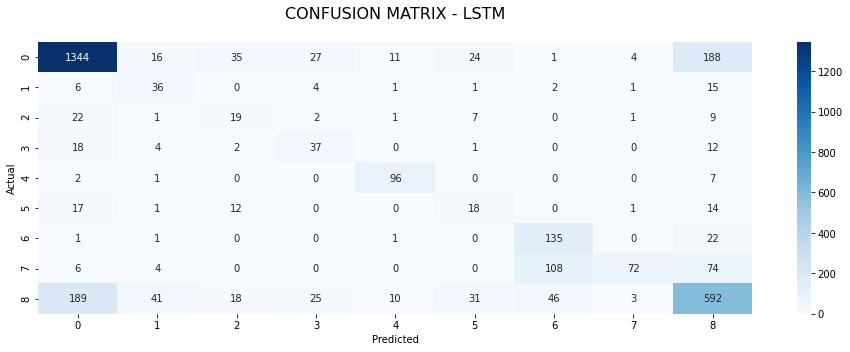

In [0]:
conf_mat=confusion_matrix(y_hat,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSTM\n", size=16);

# The results do not seem to improve any more. Let's try CNN.
ConvNets were initially developed in the neural network image processing community where they achieved break-through results in recognising an object from a pre-defined category (e.g., cat, bicycle, etc.).

A Convolutional Neural Network typically involves two operations, which can be thought of as feature extractors: convolution and pooling.

The output of this sequence of operations is then typically connected to a fully connected layer which is in principle the same as the traditional multi-layer perceptron neural network (MLP).

In the case of NLP tasks, i.e., when applied to text instead of images, we have a 1 dimensional array representing the text. Here the architecture of the ConvNets is changed to 1D convolutional-and-pooling operations.

We will to focus only in one spatial dimension. Instead of a two-dimensional filter that we would convolve over a two-dimensional input (a picture), we will convolve one-dimensional filters over a one-dimensional input, such as a sentence.



In [0]:
from tensorflow.python.keras.layers import GRU, Conv1D, MaxPool1D, SpatialDropout1D, Flatten

In [0]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='softmax'))
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 200)           3914000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 38, 16)            9616      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 16)            784       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

epochs = 20
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 2s 56ms/step - loss: 0.2347 - accuracy: 0.9092 - val_loss: 2.1831 - val_accuracy: 0.6333
Epoch 2/20
36/36 [==============================] - 1s 28ms/step - loss: 0.2258 - accuracy: 0.9146 - val_loss: 2.2001 - val_accuracy: 0.6392
Epoch 3/20
36/36 [==============================] - 1s 28ms/step - loss: 0.2247 - accuracy: 0.9118 - val_loss: 2.1097 - val_accuracy: 0.6275
Epoch 4/20
36/36 [==============================] - 1s 28ms/step - loss: 0.2273 - accuracy: 0.9118 - val_loss: 2.2317 - val_accuracy: 0.6314
Epoch 5/20
36/36 [==============================] - 1s 28ms/step - loss: 0.2288 - accuracy: 0.9105 - val_loss: 2.1897 - val_accuracy: 0.6275
Epoch 6/20
36/36 [==============================] - 1s 28ms/step - loss: 0.2246 - accuracy: 0.9115 - val_loss: 2.1488 - val_accuracy: 0.6392
Epoch 7/20
36/36 [==============================] - 1s 28ms/step - loss: 0.2228 - accuracy: 0.9135 - val_loss: 2.1823 - val_accuracy: 0.6294
Epoch 8/20
36

# CNN is not improving performance either. Let's try a combination of CNN and bi-LSTM, GRU, LSTM

In [0]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

epochs = 20
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 2s 55ms/step - loss: 1.8054 - accuracy: 0.3418 - val_loss: 1.5744 - val_accuracy: 0.4392
Epoch 2/20
36/36 [==============================] - 2s 44ms/step - loss: 1.4204 - accuracy: 0.5142 - val_loss: 1.3546 - val_accuracy: 0.5373
Epoch 3/20
36/36 [==============================] - 2s 45ms/step - loss: 1.2185 - accuracy: 0.5998 - val_loss: 1.2420 - val_accuracy: 0.5745
Epoch 4/20
36/36 [==============================] - 2s 44ms/step - loss: 1.0845 - accuracy: 0.6575 - val_loss: 1.1858 - val_accuracy: 0.5863
Epoch 5/20
36/36 [==============================] - 2s 45ms/step - loss: 0.9789 - accuracy: 0.6891 - val_loss: 1.1687 - val_accuracy: 0.6000
Epoch 6/20
36/36 [==============================] - 2s 45ms/step - loss: 0.8683 - accuracy: 0.7196 - val_loss: 1.1657 - val_accuracy: 0.6176
Epoch 7/20
36/36 [==============================] - 2s 45ms/step - loss: 0.7580 - accuracy: 0.7545 - val_loss: 1.1783 - val_accuracy: 0.6216
Epoch 8/20
36

# The accuracy has dipped.
# Tune the learning rate, use bi-lstm and remove one layer of cnn

In [0]:
from tensorflow.keras import optimizers
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))

model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Bidirectional(LSTM(16, recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(LSTM(16, recurrent_dropout=0.1)))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='softmax'))

opt=optimizers.Adam(lr=0.01)
model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])

epochs = 20
batch_size = 128

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/20
36/36 [==============================] - 8s 233ms/step - loss: 1.8247 - accuracy: 0.4514 - val_loss: 1.4459 - val_accuracy: 0.5333
Epoch 2/20
36/36 [==============================] - 7s 204ms/step - loss: 1.3217 - accuracy: 0.5771 - val_loss: 1.3007 - val_accuracy: 0.5510
Epoch 3/20
36/36 [==============================] - 7s 207ms/step - loss: 1.1487 - accuracy: 0.6440 - val_loss: 1.1796 - val_accuracy: 0.6137
Epoch 4/20
36/36 [==============================] - 7s 208ms/step - loss: 1.0186 - accuracy: 0.6978 - val_loss: 1.1442 - val_accuracy: 0.6353
Epoch 5/20
36/36 [==============================] - 7s 208ms/step - loss: 0.8981 - accuracy: 0.7307 - val_loss: 1.1217 - val_accuracy: 0.6412
Epoch 6/20
36/36 [==============================] - 7s 205ms/step - loss: 0.7779 - accuracy: 0.7599 - val_loss: 1.1181 - val_accuracy: 0.6627
Epoch 7/20
36/36 [==============================] - 7s 208ms/step - loss: 0.6884 - accuracy: 0.7878 - val_loss: 1.1562 - val_accuracy: 0.6588
Epoch 

# The results with this combination is not encouraging either. Let's try to to apply the transformer (Attention) model and compare results

In [0]:
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
from IPython.core.display import display, HTML
%matplotlib inline

In [0]:
seq_input = Input(shape=(maxlen,), dtype='int32')
embedded = Embedding(len(word_index)+1,
                     embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)(seq_input)

embedded = Dropout(0.2)(embedded)

In [0]:
lstm1 = Bidirectional(LSTM(embedding_dim, return_sequences=True))(embedded)
lstm1 = Dropout(0.2)(lstm1)
lstm2 = Bidirectional(LSTM(embedding_dim, return_sequences=True))(lstm1)
lstm2 = Dropout(0.2)(lstm2)

# Attention Mechanism

In [0]:
att_vector = TimeDistributed(Dense(1))(lstm2)
att_vector = Reshape((maxlen,))(att_vector)
att_vector = Activation('softmax', name='attention_vec')(att_vector)

In [0]:
att_output = Dot(axes=1)([lstm2, att_vector])

# Final Layers

In [0]:
fc = Dense(embedding_dim, activation='relu')(att_output)
output = Dense(9, activation='softmax')(fc)
model = Model(inputs=[seq_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 40, 200)      3914000     input_7[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 40, 200)      0           embedding_20[0][0]               
__________________________________________________________________________________________________
bidirectional_20 (Bidirectional (None, 40, 400)      641600      dropout_9[0][0]                  
______________________________________________________________________________________________

In [0]:
#Compile The Model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

history = model.fit(X, y, epochs=20, batch_size=128, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/20
36/36 - 5s - loss: 1.3121 - accuracy: 0.5728 - val_loss: 1.1076 - val_accuracy: 0.5784
Epoch 2/20
36/36 - 3s - loss: 0.9527 - accuracy: 0.6697 - val_loss: 0.9520 - val_accuracy: 0.6569
Epoch 3/20
36/36 - 3s - loss: 0.7800 - accuracy: 0.7205 - val_loss: 0.8926 - val_accuracy: 0.6647
Epoch 4/20
36/36 - 3s - loss: 0.6527 - accuracy: 0.7599 - val_loss: 0.9967 - val_accuracy: 0.6412
Epoch 5/20
36/36 - 3s - loss: 0.5226 - accuracy: 0.8002 - val_loss: 0.9278 - val_accuracy: 0.6745
Epoch 6/20
36/36 - 3s - loss: 0.4314 - accuracy: 0.8342 - val_loss: 1.0527 - val_accuracy: 0.6686
Epoch 7/20
36/36 - 3s - loss: 0.3558 - accuracy: 0.8608 - val_loss: 1.0642 - val_accuracy: 0.6706
Epoch 8/20
36/36 - 3s - loss: 0.2956 - accuracy: 0.8824 - val_loss: 1.2119 - val_accuracy: 0.6608
Epoch 9/20
36/36 - 3s - loss: 0.2365 - accuracy: 0.9011 - val_loss: 1.3017 - val_accuracy: 0.6725
Epoch 10/20
36/36 - 3s - loss: 0.2088 - accuracy: 0.9131 - val_loss: 1.3065 - val_accuracy: 0.6686
Epoch 11/20
36/36 -

In [0]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1692
           1       0.42      0.57      0.48        77
           2       0.19      0.35      0.24        46
           3       0.27      0.70      0.39        37
           4       0.89      0.88      0.88       122
           5       0.21      0.30      0.24        57
           6       0.79      0.64      0.71       360
           7       0.32      0.38      0.35        68
           8       0.63      0.62      0.63       941

    accuracy                           0.71      3400
   macro avg       0.51      0.58      0.53      3400
weighted avg       0.73      0.71      0.72      3400



# Tune the learning rate, number of lstm nodes from 200 to 64

In [0]:
seq_input = Input(shape=(maxlen,), dtype='int32')
embedded = Embedding(len(word_index)+1,
                     embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)(seq_input)

embedded = Dropout(0.2)(embedded)

lstm1 = Bidirectional(LSTM(64, return_sequences=True))(embedded)
lstm1 = Dropout(0.2)(lstm1)
lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
lstm2 = Dropout(0.2)(lstm2)

att_vector = TimeDistributed(Dense(1))(lstm2)
att_vector = Reshape((maxlen,))(att_vector)
att_vector = Activation('softmax', name='attention_vec')(att_vector)

att_output = Dot(axes=1)([lstm2, att_vector])

fc = Dense(embedding_dim, activation='relu')(att_output)
output = Dense(9, activation='softmax')(fc)
model = Model(inputs=[seq_input], outputs=output)

opt=optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])

history = model.fit(X, y, epochs=20, batch_size=128, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/20
36/36 - 4s - loss: 1.5012 - accuracy: 0.5209 - val_loss: 1.2447 - val_accuracy: 0.5588
Epoch 2/20
36/36 - 2s - loss: 1.0880 - accuracy: 0.6307 - val_loss: 1.0835 - val_accuracy: 0.6196
Epoch 3/20
36/36 - 2s - loss: 0.9043 - accuracy: 0.6913 - val_loss: 0.9400 - val_accuracy: 0.6431
Epoch 4/20
36/36 - 2s - loss: 0.7591 - accuracy: 0.7364 - val_loss: 0.9251 - val_accuracy: 0.6765
Epoch 5/20
36/36 - 2s - loss: 0.6298 - accuracy: 0.7806 - val_loss: 0.9218 - val_accuracy: 0.6980
Epoch 6/20
36/36 - 2s - loss: 0.5340 - accuracy: 0.8048 - val_loss: 0.9181 - val_accuracy: 0.7039
Epoch 7/20
36/36 - 2s - loss: 0.4531 - accuracy: 0.8266 - val_loss: 1.0095 - val_accuracy: 0.6804
Epoch 8/20
36/36 - 2s - loss: 0.3750 - accuracy: 0.8603 - val_loss: 1.0170 - val_accuracy: 0.6882
Epoch 9/20
36/36 - 2s - loss: 0.3183 - accuracy: 0.8782 - val_loss: 1.1596 - val_accuracy: 0.6863
Epoch 10/20
36/36 - 2s - loss: 0.2873 - accuracy: 0.8841 - val_loss: 1.2319 - val_accuracy: 0.6824
Epoch 11/20
36/36 -

In [0]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1792
           1       0.36      0.54      0.43        70
           2       0.24      0.34      0.29        61
           3       0.29      0.67      0.41        42
           4       0.84      0.89      0.87       113
           5       0.23      0.39      0.29        49
           6       0.52      0.75      0.61       204
           7       0.88      0.26      0.40       275
           8       0.56      0.66      0.61       794

    accuracy                           0.70      3400
   macro avg       0.54      0.59      0.53      3400
weighted avg       0.75      0.70      0.70      3400



# Looks like similar results to the first model built, with an improvement of 1% to the precision. Tune the lr and lstm layers and nodes

In [0]:
seq_input = Input(shape=(maxlen,), dtype='int32')
embedded = Embedding(len(word_index)+1,
                     embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)(seq_input)

embedded = Dropout(0.2)(embedded)

lstm1 = Bidirectional(LSTM(16, return_sequences=True))(embedded)
lstm1 = Dropout(0.2)(lstm1)
lstm2 = Bidirectional(LSTM(16, return_sequences=True))(lstm1)
lstm2 = Dropout(0.2)(lstm2)

att_vector = TimeDistributed(Dense(1))(lstm2)
att_vector = Reshape((maxlen,))(att_vector)
att_vector = Activation('softmax', name='attention_vec')(att_vector)

att_output = Dot(axes=1)([lstm2, att_vector])

fc = Dense(embedding_dim, activation='relu')(att_output)
output = Dense(9, activation='softmax')(fc)
model = Model(inputs=[seq_input], outputs=output)

opt=optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])

history = model.fit(X, y, epochs=30, batch_size=256, validation_split=0.1, shuffle=True, verbose=1)

Epoch 1/30
18/18 [==============================] - 3s 150ms/step - loss: 1.8977 - accuracy: 0.4451 - val_loss: 1.5467 - val_accuracy: 0.4392
Epoch 2/30
18/18 [==============================] - 1s 64ms/step - loss: 1.4509 - accuracy: 0.5059 - val_loss: 1.4211 - val_accuracy: 0.5333
Epoch 3/30
18/18 [==============================] - 1s 64ms/step - loss: 1.2783 - accuracy: 0.5732 - val_loss: 1.2642 - val_accuracy: 0.5725
Epoch 4/30
18/18 [==============================] - 1s 63ms/step - loss: 1.1349 - accuracy: 0.6292 - val_loss: 1.1828 - val_accuracy: 0.5882
Epoch 5/30
18/18 [==============================] - 1s 66ms/step - loss: 1.0312 - accuracy: 0.6573 - val_loss: 1.1110 - val_accuracy: 0.6078
Epoch 6/30
18/18 [==============================] - 1s 64ms/step - loss: 0.9458 - accuracy: 0.6952 - val_loss: 1.0611 - val_accuracy: 0.6490
Epoch 7/30
18/18 [==============================] - 1s 64ms/step - loss: 0.8511 - accuracy: 0.7333 - val_loss: 1.0501 - val_accuracy: 0.6412
Epoch 8/30
1

In [0]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1586
           1       0.30      0.45      0.36        71
           2       0.16      0.16      0.16        88
           3       0.29      0.48      0.37        58
           4       0.86      0.91      0.88       113
           5       0.09      0.24      0.13        29
           6       0.79      0.61      0.69       377
           7       0.05      0.20      0.08        20
           8       0.65      0.57      0.61      1058

    accuracy                           0.68      3400
   macro avg       0.44      0.49      0.45      3400
weighted avg       0.71      0.68      0.69      3400



In [0]:
# The accuracy dropped and hence this is not the best model. More experimentation required to arrive at better model

# Words like com, company, gmail etc which have a very frequency may not be adding much value to the model we will build. We may want to remove such common high frequency word by adding them to the stopwords and try the models again

In [0]:
df['Cleaned_Description'] = cleaned_text
gen_freq(df['Cleaned_Description'].str)[0:50]

job              2510
password         1042
scheduler         959
erp               875
failed            828
tool              726
unable            717
reset             691
sid               590
account           500
issue             487
access            465
outlook           408
hostname          351
company           320
login             314
locked            297
working           291
error             280
ticket            277
user              264
vpn               252
update            251
please            230
skype             221
engineering       216
crm               208
since             204
et                204
need              204
cannot            184
windows           183
management        175
usa               173
outage            167
new               161
network           156
printer           149
unlock            148
abended           148
collaboration     146
email             146
platform          145
help              144
open              141
server    

# Additional words to be removed
com, company, gmail, hello, id, sid,able, cid, name, na, server, team, hi,please

In [0]:
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
#nlp = spacy.load('en', parser=False, entity=False)

#stop_words = stopwords.words('english')
#customize_stop_words=['com', 'company', 'gmail', 'hello', 'id', 'sid', 'able', 'cid', 'name', 'na','server', 'team','hi','please', 'hostname']

# Mark them as stop words
#for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [0]:
# Convert each row into spacy document and return the lemma of the tokens in 
# the document if it is not a sotp word. Finally join the lemmas into as a string
#df['Cleaned_Description'] = df['Cleaned_Description'].apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop))

# Removing the additional words does not seem to improve the result. Revert back to the text with the words attempted to be removed in the previous iteration

In [0]:
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

# Create an ensemble of models to improve precision

In [0]:
nets = 7
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Embedding(len(word_index)+1,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))
    
    model[j].add(SpatialDropout1D(0.2))
    model[j].add(Bidirectional(LSTM(64, recurrent_dropout=0.1,return_sequences=True)))
    model[j].add(Bidirectional(LSTM(64, recurrent_dropout=0.1)))
    model[j].add(Dropout(0.25))

    model[j].add(Dense(64, activation='relu'))
    model[j].add(Dense(9, activation='softmax'))
        
    opt=optimizers.Adam(lr=0.001)

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
# TRAIN NETWORKS
history = [0] * nets
epochs = 30
batch_size = 128

for j in range(nets):
    
    history[j] = model[j].fit(X,y,epochs = epochs, validation_split = 0.2, verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 1: Epochs=30, Train accuracy=0.98848, Validation accuracy=0.72843
CNN 2: Epochs=30, Train accuracy=0.98652, Validation accuracy=0.72843
CNN 3: Epochs=30, Train accuracy=0.98652, Validation accuracy=0.72255
CNN 4: Epochs=30, Train accuracy=0.98603, Validation accuracy=0.71569
CNN 5: Epochs=30, Train accuracy=0.98775, Validation accuracy=0.72451
CNN 6: Epochs=30, Train accuracy=0.98603, Validation accuracy=0.72157
CNN 7: Epochs=30, Train accuracy=0.98505, Validation accuracy=0.72353


In [0]:
X_test = tokenizer.texts_to_sequences(test['Consolidated_Text'])
X_test = pad_sequences(X_test, maxlen = maxlen)

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test['New_AssignmentGroup'])
y_test=le.transform(test['New_AssignmentGroup'])

In [0]:
# ENSEMBLE PREDICTIONS
results = np.zeros( (X_test.shape[0],9) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(results, y_test))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1708
           1       0.30      0.52      0.38        60
           2       0.16      0.29      0.21        49
           3       0.35      0.67      0.46        49
           4       0.87      0.90      0.88       116
           5       0.28      0.46      0.35        50
           6       0.70      0.78      0.73       261
           7       0.63      0.62      0.63        84
           8       0.69      0.63      0.66      1023

    accuracy                           0.73      3400
   macro avg       0.54      0.63      0.57      3400
weighted avg       0.76      0.73      0.74      3400



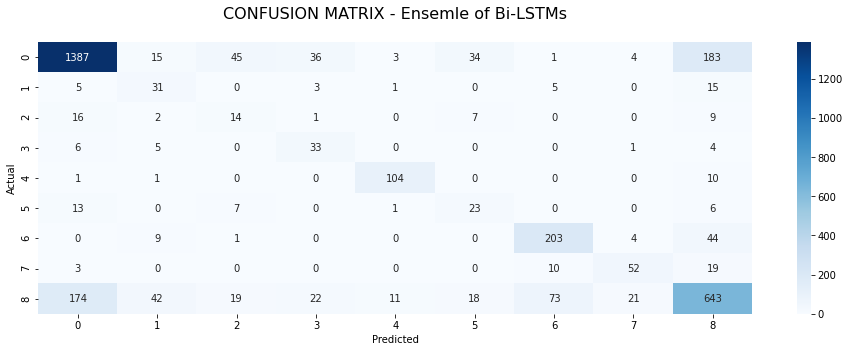

In [0]:
conf_mat=confusion_matrix(results,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Ensemle of Bi-LSTMs\n", size=16);

In [0]:
The best results achieved so far is with the ensemble model as seen above. This model should be recommended to be installed in production

# TRY transfer learning via ULMFiT

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
from sklearn.model_selection import train_test_split
df=df.loc[:,['New_AssignmentGroup', 'Consolidated_Text']]
# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['New_AssignmentGroup'], test_size = 0.1, random_state = 12)

In [0]:
df_trn.shape, df_val.shape

((7650, 2), (850, 2))

# Data Preparation for Transfer Learning

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.7)

In [0]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.895064,5.316730,0.254420,00:15


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


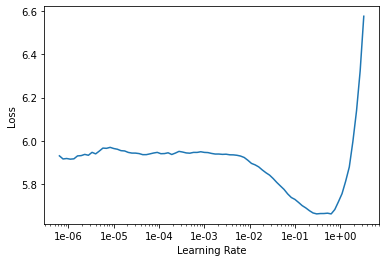

In [0]:
learn.recorder.plot()

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, arch = AWD_LSTM,drop_mult=0.7)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7650 items)
x: TextList
xxbos bcxfhekz bplfrnis exited company need forward bcxfhekz bplfrnis emails zneyrlhg bfiwanze effective xxunk bcxfhekz bplfrnis emails zneyrlhg xxunk bfiwanze,xxbos tablet sound xxunk sound workingeqxakzyi cwfrjitq,xxbos received vkzwibco pueyvhoi gmail com dear ms ragsbdhryu line xxunk conversation please find following details two computers machine pc laptop two connected using lan cable name laptop visible networks page machine pc name machine pc visible network laptop unable set domain name workgroup settings control panel please sort xxunk issue customer xxunk pueyvhoi,xxbos jgdydqqd locked tried going onto password management tool reset password jgdydqqd listed please unlock account xxunk access xxunk ogrhivnm,xxbos received hkrecpfv kgwpbexv gmail com hello believe computer downloaded new symantec endpoint encryption agent concerned yet received email almost month xxunk endpoint encryption agent xxunk

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


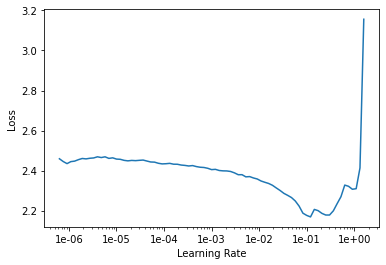

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
The results achieved from the transfer learning model i.e. ULMFit was not encouraging and further research in the area is required to see if better results can be achieved

# Conclusions & Next Steps


*   Traditional ML models with tf-idf embeddings did not give encouraging results
*   Multiple deep learning sequential models with GloVe Embeddings were attempted and results compared to arrive at the best model. The two best models are highlighted below through their results. 
*   Bi-Directional LSTM attempted on the data set after aggregating all groups with less than 200 frequency has given an accuracy of 71% and precision of 71%.
*   The accuracy and precision was further improved to 73% to 76% respectively when an ensemble of 7 Bi-LSTM was built.
*   In both the above attempts, the precision for Group_0 was even higher i.e. 82% and 86% respectively 
*   Since Group_0 constitutes close to 50% of total population, with 82% precision, we are likely to achive an automation of close to 40% with Group_0 itself.

*   With an average precision of 76%, we are expecting to save around 269 minutes of reading time (for reading 8500 tickets raised manually), considering each document takes 2.5 secs to read 

*   The team would continue to focus on experimenting to improve the precision further and with it the level of automation
*   Considering that this is a highly imbalanced dataset, it is always going to be a trade off between the automating routing of tickets to more groups or automating routing more accurately to lesser groups
*   The ensemble model gives us the best result and should be recommended for installation in production environment

* Future work would include applying smote to make the data balanced and re-trying the models to see if the results are improving
